In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchtext.data import Field, BucketIterator, TabularDataset
from torch.utils.tensorboard import SummaryWriter

import spacy
import math
import random
import nltk
from nltk.corpus import stopwords
from string import punctuation
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [49]:
while 1:
    x = np.array([1,2,3])
    y = np.array([1,2,3])
    z = x * y.T

KeyboardInterrupt: ignored

# **Loading and Preprocessing**

In [2]:
data = pd.read_csv("/content/drive/My Drive/news_summary_more.csv")
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [4]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data, test_size = 0.1, shuffle = True)
valid, test = train_test_split(valid, test_size = 0.1, shuffle = True)

In [8]:
train.to_csv("train.csv", index = False)
valid.to_csv("valid.csv", index = False)
test.to_csv("test.csv", index = False)

In [57]:
headlines = data['headlines'].tolist()
text = data['text'].tolist()

In [58]:
headline_length = [len(x.split()) for x in headlines]
text_length = [len(x.split()) for x in text]

(array([1.0000e+00, 1.4000e+01, 1.4840e+03, 5.4910e+03, 4.1552e+04,
        4.1212e+04, 6.3630e+03, 2.2060e+03, 7.7000e+01, 1.0000e+00]),
 array([ 1. ,  2.7,  4.4,  6.1,  7.8,  9.5, 11.2, 12.9, 14.6, 16.3, 18. ]),
 <a list of 10 Patch objects>)

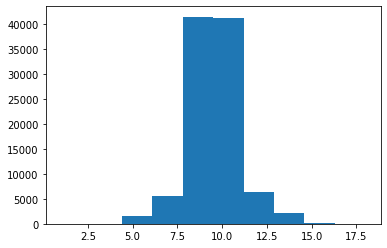

In [11]:
plt.hist(headline_length, bins = 10)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.2000e+01,
        2.4400e+02, 3.3620e+03, 2.2697e+04, 7.2036e+04, 3.8000e+01]),
 array([ 1.        ,  5.33333333,  9.66666667, 14.        , 18.33333333,
        22.66666667, 27.        , 31.33333333, 35.66666667, 40.        ,
        44.33333333, 48.66666667, 53.        , 57.33333333, 61.66666667,
        66.        ]),
 <a list of 15 Patch objects>)

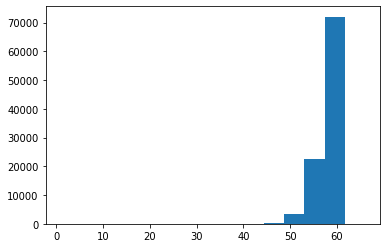

In [12]:
plt.hist(text_length, bins = 15)

In [13]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [14]:
source = Field(sequential = True, use_vocab = True, init_token = '<sos>', eos_token = '<eos>', lower = True, tokenize = 'spacy')
target = Field(sequential = True, use_vocab = True, init_token = '<sos>', eos_token = '<eos>', lower = True, tokenize = 'spacy')

In [63]:
train, valid, test = TabularDataset.splits(path = '/content', train = 'train.csv', validation = 'valid.csv', test = 'test.csv',
                                           format = 'csv', fields = [('headlines', target), ('text', source)])

In [36]:
source.build_vocab(train, max_size = 10000, min_freq = 2)
target.build_vocab(train, max_size = 10000, min_freq = 2)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# **Building the model**

In [18]:
#We are creating a model where the encoder hidden states and the decoder hidden states have the same dimension

class Encoder(nn.Module):
    def __init__(self, input_dim, embedd_dim, hidden_dim, n_layers, drop_prob):
        super().__init__()
        self.input_dim = input_dim
        self.embedd_dim = embedd_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embed = nn.Embedding(input_dim, embedd_dim)

        self.gru = nn.GRU(embedd_dim, hidden_dim, num_layers = n_layers, dropout = drop_prob, bidirectional = True)

        self.fc = nn.Linear(hidden_dim*2, hidden_dim)

        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, x):
        #shape of x = [sentence_length, batch_size]
        
        embedding = self.dropout(self.embed(x))
        #shape of embedding = [sentence_len, batch_size, embedd_dim]

        encoder_state, hidden = self.gru(embedding)
        #shape of encoder_state = [sentence_len, batch_size, hidden_dim]
        #shape of hidden = [num_directions * num_layers, batch_size, hidden_dim] ->is of the last time step

        hidden = self.fc(torch.cat((hidden[0:1], hidden[1:2]), dim = 2))
        #since hidden shape will be [2, batch_size, hidden_dim] and we want it to be [batch_size, hidden_dim*2] so that it can be passed to the fully connected layer
        #nn.GRU()
        return encoder_state, hidden

In [19]:
class Decoder(nn.Module):
    def __init__(self, input_dim, embedd_dim, hidden_dim, output_dim, n_layers, drop_prob):
        super().__init__()

        self.input_dim = input_dim
        self.embedd_dim = embedd_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob

        self.embed = nn.Embedding(input_dim, embedd_dim)
        
        self.gru = nn.GRU(embedd_dim + hidden_dim*2, hidden_dim, num_layers = n_layers)
        #embedd_dim for the input word and hidden_dim from the context produced by the encoder

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p = drop_prob)
        self.energy = nn.Linear(hidden_dim*3, 1) #2 from the encoder state and 1 from previous decoder
        self.softmax = nn.Softmax(dim = 0)
        self.relu = nn.ReLU()      

    def forward(self, x, encoder_state, hidden):
        #x will be a word per batch, i.e. shape of x = [batch_size], but we want it to be [1, batch_size] so as to explicitly state 1 word per batch
        x = x.unsqueeze(dim = 0)

        embedd = self.dropout(self.embed(x))
        #embedd shape = [1, batch_size, embedd_dim]
        #hidden shape = [batch_size, hidden_dim]
        #encoder_state shape = [sentence_len, batch_size, hidden_dim*2]

        sentence_length = encoder_state.shape[0]
        hidden_reshaped = hidden.repeat(sentence_length, 1, 1)
        #hidden_reshaped shape = [sentence_length, batch_size, hidden_dim]

        energy = self.relu(self.energy(torch.cat((hidden_reshaped, encoder_state), dim = 2)))
        #energy shape = [sentence_len, batch_size, 1]

        attention = self.softmax(energy)
        #attention shape = [sentence_len, batch_size, 1]

        attention = attention.permute(1, 2, 0)
        #attention = [batch_size, 1, sentence_len]
        encoder_state = encoder_state.permute(1, 0, 2)
        #encoder_state = [batch_size, sentence_len, hidden_dim*2]

        context_vector = torch.bmm(attention, encoder_state).permute(1, 0, 2)
        #context_vector = [1, batch_size, hidden_dim*2]

        rnn_input = torch.cat((context_vector, embedd), dim = 2)
        #rnn_input = [1, batch_size, embedd_dim + hidden_dim*2]

        outputs, hidden = self.gru(rnn_input, hidden) 
        #outputs = [1, batch_size, hidden_dim]

        predictions = self.fc(outputs).squeeze(dim = 0)
        #predictions = [batch_size, output_dim]

        return predictions, hidden

In [20]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source_sentence, target_sentence, teacher_forcing_ratio = 0.5):
        #source_sentence = [sentence_len, batch_size]
        #target_sentence = [target_len, batch_size]

        batch_size = source_sentence.shape[1]
        target_len = target_sentence.shape[0]
        target_vocab_size = len(target.vocab)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        #for each batch, we want a target sentence of length target len, and each of those positions will have some probability for each word

        encoder_state, hidden = self.encoder(source_sentence)

        first_word = target_sentence[0]
        #first word is <SOS> token

        for word in range(1, target_len):
            output, hidden = self.decoder(first_word, encoder_state, hidden)

            outputs[word] = output

            best_guess = output.argmax(1)

            x = target_sentence[word] if random.random() < teacher_forcing_ratio else best_guess
        
        return outputs

In [37]:
num_epochs = 30
learning_rate = 3e-4
batch_size = 32

input_size_encoder = len(source.vocab)
input_size_decoder = len(target.vocab)
output_size = len(target.vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 1024
num_layers = 1
enc_dropout = 0
dec_dropout = 0

In [38]:
writer = SummaryWriter(f"runs/loss_plot")
step = 0

train_iter, valid_iter, test_iter = BucketIterator.splits((train, valid, test), batch_sizes = (batch_size, batch_size, batch_size), sort_within_batch = True, sort_key = lambda x : len(x.headlines), device = device)

In [40]:
encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout)
decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dec_dropout)

In [41]:
model = Seq2Seq(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [42]:
pad_idx = target.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)

In [44]:
step = 0
print_every = 100
for epoch in range(1, num_epochs+1):
    print(f"[Epoch {epoch} / {num_epochs}]")

    model.train()

    for idx, batch in enumerate(train_iter):
        input_data = batch.text.to(device)
        targ = batch.headlines.to(device)

        output = model(input_data, targ)

        #output is of shape [target_len, batch_size, output_dim] but cross entropy doesn't accept in that form, so we reshape it as follows
        output = output[1:].reshape(-1, output.shape[2])
        targ = targ[1:].reshape(-1)
        #we're doing [1:] so as to not consider the start token

        optimizer.zero_grad()
        loss = criterion(output, targ)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2)

        optimizer.step()

        writer.add_scalar("Training loss", loss, global_step = step)
        step += 1

        if step % print_every == 0:
            print(f"[Step : {step}, '\t', Loss : {loss.item()/batch_size}]")    

[Epoch 1 / 30]
[Step : 100, '	', Loss : 0.21468855440616608]
[Step : 200, '	', Loss : 0.22141076624393463]
[Step : 300, '	', Loss : 0.20844396948814392]
[Step : 400, '	', Loss : 0.19881239533424377]
[Step : 500, '	', Loss : 0.19567663967609406]
[Step : 600, '	', Loss : 0.18355108797550201]
[Step : 700, '	', Loss : 0.19012056291103363]
[Step : 800, '	', Loss : 0.185635045170784]
[Step : 900, '	', Loss : 0.17785464227199554]
[Step : 1000, '	', Loss : 0.1810442954301834]
[Step : 1100, '	', Loss : 0.17285865545272827]
[Step : 1200, '	', Loss : 0.18881745636463165]
[Step : 1300, '	', Loss : 0.17438724637031555]
[Step : 1400, '	', Loss : 0.18037399649620056]
[Step : 1500, '	', Loss : 0.17238134145736694]
[Step : 1600, '	', Loss : 0.17071887850761414]
[Step : 1700, '	', Loss : 0.16919410228729248]
[Step : 1800, '	', Loss : 0.16184963285923004]
[Step : 1900, '	', Loss : 0.17529553174972534]
[Step : 2000, '	', Loss : 0.1719479113817215]
[Step : 2100, '	', Loss : 0.16446921229362488]
[Step : 220

In [48]:
print_every = 20
for epoch in range(1, num_epochs+1):

    model.eval()

    step = 0

    with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            input_data = batch.text.to(device)
            targ = batch.headlines.to(device)

            output = model(input_data, targ, teacher_forcing_ratio = 0)

            output = output[1:].reshape(-1, output.shape[2])
            targ = targ[1:].reshape(-1)

            loss = criterion(output, targ)

            step += 1

            if step % print_every == 0:
                print(f"[Step : {step}, Loss : {loss.item()/batch_size}]")

[Step : 20, Loss : 0.2658458948135376]
[Step : 40, Loss : 0.2695620059967041]
[Step : 60, Loss : 0.2668425440788269]
[Step : 80, Loss : 0.2606973946094513]
[Step : 100, Loss : 0.23340405523777008]
[Step : 120, Loss : 0.2436288446187973]
[Step : 140, Loss : 0.26474714279174805]
[Step : 160, Loss : 0.25943365693092346]
[Step : 180, Loss : 0.2434902787208557]
[Step : 200, Loss : 0.2541641891002655]
[Step : 220, Loss : 0.2534291446208954]
[Step : 240, Loss : 0.25864899158477783]
[Step : 260, Loss : 0.2828618586063385]
[Step : 20, Loss : 0.2658458948135376]
[Step : 40, Loss : 0.2695620059967041]
[Step : 60, Loss : 0.2668425440788269]
[Step : 80, Loss : 0.2606973946094513]
[Step : 100, Loss : 0.23340405523777008]
[Step : 120, Loss : 0.2436288446187973]
[Step : 140, Loss : 0.26474714279174805]
[Step : 160, Loss : 0.25943365693092346]
[Step : 180, Loss : 0.2434902787208557]
[Step : 200, Loss : 0.2541641891002655]
[Step : 220, Loss : 0.2534291446208954]
[Step : 240, Loss : 0.25864899158477783]


KeyboardInterrupt: ignored

# **Predictions**

In [72]:
def predict(sentence, source_field, target_field, model, device, max_len = 20):
    model.eval()

    if sentence is str:
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [source_field.init_token] + tokens + [source_field.eos_token]
    source_idxs = [source_field.vocab.stoi[token] for token in tokens]

    source_tensor = torch.LongTensor(source_idxs).unsqueeze(dim = 1).to(device)
    #source_len = torch.LongTensor([len(source_idxs)]).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(source_tensor)
    
    target_idxs = [target_field.vocab.stoi[target_field.init_token]]
    
    for i in range(max_len):

        target_tensor = torch.LongTensor([target_idxs[-1]]).to(device)

        with torch.no_grad():
            predictions, hidden = model.decoder(target_tensor, encoder_outputs, hidden)
        
        pred_token = predictions.argmax(1).item()
        target_idxs.append(pred_token)

        if pred_token == target_field.vocab.stoi[target_field.eos_token]:
            break
    
    target_tokens = [target_field.vocab.itos[i] for i in target_idxs]

    return target_tokens[1:]

In [82]:
random_idx = random.randint(1, len(test.examples)+1)
sample_text = vars(test.examples[random_idx])['text']
sample_headline = vars(test.examples[random_idx])['headlines']
predicted_headline = predict(sample_text, source, target, model, device)

print("Text : ", " ".join(word for word in sample_text))
print("Headline : ", " ".join(word for word in sample_headline))
print("Predicted Headline : ", " ".join(word for word in predicted_headline))

Text :  hindu jagarana vedike leader jagadish karanth has reportedly been booked for making provocative comments and promoting enmity on grounds of religion during a protest meet in mangaluru , among other charges . karanth allegedly said police officer khaled should be " stripped naked and made to run around in the bus stop " , while claiming that khaled had illegally broken into a lawyer 's residence .
Headline :  hindu jagarana vedike leader booked for provocative speech
Predicted Headline :  kashmir leader leader sacked over making protests <eos>
